# Abstract

### Introducción

En este trabajo comparamos módelos de predicción clásicos como pudiera ser regresión PLS con diferentes tipos de redes neuronales. 

### Métodos

Redes neuronales con redu, y PLS.

### Conclusión

...

# Índice

*   [Modelo de predicción con redes neuronales](#modeloredes)

  - [Librerías](#librerias)
  - [Cargar el conjunto de datos](#cargardatos)
  - [Definición de los modelos](#definicionmodelos)
  - [Entrenamiento de los modelos](#entrenamientomodelos)



[Árboles para la predicción de morfología de la red](#arboles)

[Modelo de predicción usando PLS](#pls)



<a name="modeloredes"></a>
# Modelo de predicción con redes neuronales

<a name="librerias"></a>
## Librerías
Primero cargamos las librerias que vamos a usar.


*   [Tensorflow](https://es.wikipedia.org/wiki/TensorFlow) es una librería de código abierto para trabajar con resdes neuronales. En python, la interfaz con Tensorflow se llama [Keras](https://es.wikipedia.org/wiki/Keras).
*   [Numpy](https://es.wikipedia.org/wiki/NumPy) es una librería con funciones matemáticas comunes y para el uso de matrices y vectores grandes.
*   [Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una librería para el uso de dataframes.
*   [Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una librearía para la generación de gráficos en 2D.
*   Random para la selección aleatoria en el balanceo de datos



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Cargamos también el entorno de Google Drive que es donde están los datos

In [ ]:
# Libreria para el uso de archivos
from google.colab import drive

# Montar el disco de drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Comprobamos que el disco de drive funciona; 'ls' es una función que simplemente lista los archivos de un directorio en una terminal de linux.

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"


balanced_data.R  datos	PaperTest2.ipynb  TutorialML.ipynb


<a name="cargardatos"></a>
## Cargar el conjunto de datos

Cargamos los datos en memoria y comprobamos que todo funciona

In [ ]:
# Definimos donde están los directorios y archivos que hagan falta
# -- Dónde está el directorio principal
project_folder = "/content/drive/My Drive/Colab Notebooks/"
# -- Dónde están los datos dentro del directorio principal
#    Elegimos entre los datos de prueba o los datos principales

# PRUEBA:
#             Conjunto de datos pequeño de 100 muestras
#
# PRINCIPAL:
#
#             Conjunto de datos grande con 400 muestras. Está sin balancear y
#             se usa para probar el algoritmo de balanceo.
#
# TOTAL:
#
#             Son los datos reales con todas las muestras, 25MB y lento de
#             ejecutar, pero resultados reales.


#option = "prueba"
#option = "principal"
option = "total"


# Declaramos las variables donde se guardan los datos
data = None
X    = None
Y    = None

# Para los datos de prueba
if option == "prueba":

  data_file      = "/datos/modelo4_n100.txt"

  # Cárgamos el archivo en un dataframe y le ponemos nombres a las variables
  data = pd.read_csv( project_folder + data_file, sep = " ")
  data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10' , 'Y']

  # Separammos los datos y definimos las matrices X e Y
  X = data.iloc[:,0:10]
  Y = data.iloc[:,10]


# Resto de opciones
else:

  # Para los datos de prueba
  if option == "principal":

    data_file      = "/datos/sensor.txt"

    # Cárgamos el archivo en un dataframe
    # NOTA: Falta la columna para el sesonr 15, esto es correcto
    data = pd.read_csv( project_folder + data_file, sep = " ", header=0)
  
    # Separammos los datos y definimos las matrices X e Y
    X = data.iloc[:,0:51]
    Y = data.iloc[:,51]

    print(data.shape[0])
    print(data.shape[1])

    # Seleccionamos las X más importantes
    #
    X = data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 38, 40, 51]]
  

  # Para los datos totales
  else:

    # Hay que usar sensor.csv de 120MB

    # Interpolar los datos de X que faltan, y comprobar que no sean un Y = 0

    # FALTA DECICIDIR QUE HACER CON LA COLUMNA 'RUL' QUE ES LA Y = {0,1}
    # EN CASOS ANTERIORES

    data_file      = "/datos/sensor.csv"             
                                                      

    # Cárgamos el archivo en un dataframe
    # NOTA: La columna para el sesonr 15 está vacía, esto es correcto
    data = pd.read_csv( project_folder + data_file, sep = ",", header=0)
  
    print(data.shape[0])
    print(data.shape[1])

    # Eliminamos las dos primeras columnas que son la fecha y el índice
    data = data.drop(data.columns[[0]], axis=1) # axis = 1 significa columna
    data = data.drop(data.columns[[0]], axis=1) 

    print(data.shape[0])
    print(data.shape[1])

    # Cambiamos los estados de Y, que vienen como
    #      {NORMAL, BROKEN, RECOVERING}
    #      {1     , 0     , 0}
    data['new'] = 1
    for i in range(0,data.shape[0]):
      if ( (data.iat[i, data.shape[1]-2] ) != "NORMAL"):
        data.iat[i, data.shape[1]-1] = 0

    # Borramos la columna de Y antigua
    data = data.drop(data.columns[[  data.shape[1]-2  ]], axis=1) 

    # Separammos los datos y definimos las matrices X e Y
    X = data.iloc[:,0:data.shape[1]-1]
    Y = data.iloc[:,data.shape[1]-1]

    # Seleccionamos las X más importantes
    #
    X = data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 38+1, 40+1, 51+1]] 



# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = X.shape[0]
totalInputsColumns = X.shape[1]

220320
55
220320
53


## Balanceo de datos

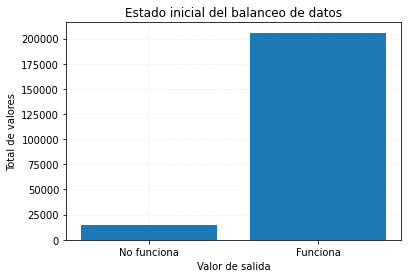

In [ ]:
# Comprobamos el estado de las Ys


# Podemos hacer:
#
#   DOWNSAMPLING - Quitar filas de 1s hasta tener los mismos 0s
#
#   UPSAMPLING   - Añadir filas de 0s hasta tener los mismos 1s


# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)

 
# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
plt.show()


In [ ]:
# No está balanceado.

# Comprobamos que filas tienen 0s y cuales tienen 1s
trueRows  = [i for i, x in enumerate(Y) if x == 1]
falseRows = [i for i, x in enumerate(Y) if x == 0]

# Elegimos la opción que queremos
balanceOption = "Downsampling"
#balanceOption = "Upsampling"

# Para la opción de eliminar datos con Y = 1
if balanceOption == "Downsampling":

  # /!\ Hablamos de elegir datos de forma aleatoria, o elegir datos que estén en las X anteriores filas de Y = 0 ? <------------------------------

  # Elegimos las filas con 1s de forma aleatoria
  finalRows = random.choices(trueRows, k = salida_data['No funciona'])

  # Añadimos las filas que tienen 0s
  finalRows = finalRows + falseRows
  finalRows.sort()
  
  # Eliminamos el resto del conjunto de datos
  X = X.iloc[ finalRows , : ]
  totalInputsRows  = X.shape[0]
  Y = X.iloc[:,16]


else:

  print("TODO")



[17155, 17156, 17157, 17158, 17159, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175, 17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17217, 17218, 17219, 17220, 17221, 17222, 17223, 17224, 17225, 17226, 17227, 17228, 17229, 17230, 17231, 17232, 17233, 17234, 17235, 17236, 17237, 17238, 17239, 17240, 17241, 17242, 17243, 17244, 17245, 17246, 17247, 17248, 17249, 17250, 17251, 17252, 17253, 17254, 17255, 17256, 17257, 17258, 17259, 17260, 17261, 17262, 17263, 17264, 17265, 17266, 17267, 17268, 17269, 17270, 17271, 17272, 17273, 17274, 17275, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17297

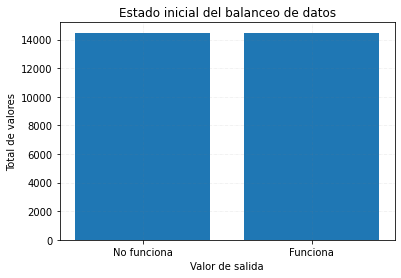

In [ ]:
# Comprobamos el estado de las Ys


# Podemos hacer:
#
#   DOWNSAMPLING - Quitar filas de 1s hasta tener los mismos 0s
#
#   UPSAMPLING   - Añadir filas de 0s hasta tener los mismos 1s


# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = totalInputsRows - salida_data['Funciona']

 
# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
plt.show()

<a name="definicionmodelos"></a>

### Definimos el modelo.

En este caso tenemos que ir cambiando variables hasta que el modelo salga mejor. Por defecto usamos los siguientes parámetros que iremos refinando en los siguientes pasos:


*   **Red sequencial densa.** Esto significa que cada neurón de cada capa está conectado a todos los neurones de la capa siguiente.

*   **Activación ReLu** para capas intermedias. En el modelo recursivo no usaremos [ReLu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)).

*   **Activación sigmoide** para la capa final de salida.

*   El **algoritmo de optimización** para el modelo es **ADAM**, que es una combinación de Adaptive Gradient Algorithm (AdaGrad) con Root Mean Square Propagation (RMSProp). Este algoritmo es el mejor algoritmo básico y se adapta muy bien a toda clase de problemas.

*   **Función de pérdida mediante entropía cruzada binaria.** El modelo necesita un estimador para la [función de pérdida](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_p%C3%A9rdida) para cada paso del algoritmo de optimización. Por defecto se suele usar el MSE (Error medio de cuadrados) para la función de regresión, pero en este caso en particular el modelo es un clasificador binario y sale mejor con [entropía binaria cruzada](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

*    **Look Back** Para el caso particular del modelo D que usa series temporales, cuantos pasos hacia atrás debe usar para calcular la salida. 

Vamos a probar con 3 modelos diferentes para comparar. Cada red neuronal tiene 10 entradas (X) y una salida (Y):


*   **Modelo A:** Una red de 2 capas intermedias de 10 neurones cada una. 

*   **Modelo B:** Una red sin capas intermedias.

*   **Modelo C:** Una red de 1 capa intermedia con 4 neurones.

Vamos a probar también con 1 modelo que tiene en cuenta la serie temporal de datos. Este es modelo de redes neuronales recurrentes (RNN), y en particular usamos la arquitectura [LSMT](https://www.youtube.com/watch?v=YCzL96nL7j0). Tiene 10 entradas (X) más una entrada de memoria corta (valor anterior) más tantas entradas de memoria larga como definamos. 


*   **Modelo D:** Una red de 1 capa intermedia con 4 neurones.

In [ ]:
# Definir la forma que tiene la entrada de datos, en nuestro caso, son 10 columnas
# y 100 filas. En este caso el número de filas nos da igual porque no tenemos
# una imagen de dimensiones fijas; tenemos un conjunto de 10 variables, con la
# cantidad de muestras que sean.
#
# ---- Para los modelos lineales de redes neuronales
myInputShape     = (totalInputsColumns,)
# ---- Para los modelos recursivos
look_back        = 1
myRecurrentShape = (look_back, totalInputsColumns)

# Para los modelos lineales
# Vamos a usar 3 modelos y comparar la función LOSS de cada uno.
#
# -- Módelo A, una red con dos capas intermedias 10 x 10
# -- Módelo B, una red sin capas intermedias, sólamente 10 entradas y 1 salida.
# -- Módelo C, una red con una única capa intermedia de 4 neurones 

# Para el modelo A, definimos las siguientes capas ocultas:
modeloA_ocultaA = tf.keras.layers.Dense(units = 10, input_shape = myInputShape, activation = 'relu')
modeloA_ocultaB = tf.keras.layers.Dense(units = 10, activation = 'relu')
modeloA_salida  = tf.keras.layers.Dense(units = 1,  activation = 'sigmoid')

# Para el modelo B, definimos la capa simple sin nada intermedio
modeloB_simple = tf.keras.layers.Dense(units = 1, input_shape = myInputShape, activation = 'sigmoid')

# Para el modelo C, definimos la única capa intermedia
modeloC_ocultaA = tf.keras.layers.Dense(units = 4, input_shape = myInputShape, activation = 'relu')
modeloC_salida  = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')


# Para el modelo recursivo
# Vamos a usar 1 modelo, e igualmente comparar la función LOSS con los anteriores
#
# -- Modelo D, una red con una cápa de 4 neurones connectando con las 3 entradas anteriores.
# Para el modelo D, definimos la única capa intermedia como capa LSTM
modeloD_ocultaA = tf.keras.layers.LSTM(units = 11,  input_shape = myRecurrentShape, activation = 'relu') 
modeloD_salida  = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')


# Creamos cada uno de los modelos
modeloA = tf.keras.Sequential([modeloA_ocultaA, modeloA_ocultaB, modeloA_salida])
modeloB = tf.keras.Sequential([modeloB_simple])
modeloC = tf.keras.Sequential([modeloC_ocultaA, modeloC_salida])
modeloD = tf.keras.Sequential([modeloD_ocultaA, modeloD_salida])


# Compilamos cada uno de los modelos
modeloA.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )
modeloB.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )
modeloC.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )
modeloD.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )


# Para el modelo D en particular, hay que transformar los datos de forma
# matricial a forma de series de datos.

# ---- Creamos los arrays donde poner los datos
Xnew = []
Ynew = []
# ---- Agrupar los datos en grupos de look_back, para cada grupo hay una Y
for i in range(len(X) - look_back - 1):

    t = []
    for j in range(0, look_back):
        t.append( X.iloc[(i + j), :]  )
        
    Xnew.append(t)
    Ynew.append(Y.iloc[ i + look_back])

# ---- Hasta aquí, los datos están ya bien agrupados. Pero la función para
#      LSTM no quiere los datos en forma de dataframe, hay que dárselos en forma
#      de listas de listas.
Xnew = np.array(Xnew)
Ynew = np.array(Ynew)
Xnew = Xnew.reshape(Xnew.shape[0],look_back, totalInputsColumns)

<a name="entrenamientomodelos"></a>
### Entrenamiento del modelo.

En esta sección entrenamos el modelo. Esta es la parte que es computacionalmente más pesada, pero al ser este un modelo bastante simple con una matriz pequeña, no tarda mucho. Hay que darle 2 parámetros:


*   **Épocas.** Esto es cuanta paciencia tienes para entrenar el modelo. Es el número de pasos que va seguir hasta que converja (o no) a un LOSS que sea aceptable.

*   **Tamaño del lote** Cada una de las filas de la matriz X es una muestra. Aquí se define cuantas muestras se usan en cada paso del algoritmo. Puedes usar las [siguientes configuraciones](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/):

    - **Stochastic Gradient Descent.** <font color='red'> Tamaño = 1. </font>   Fácil de entender, pero suele ser inestable y dar demasiados saltos sin que encuentre convergencia.

    - **Mini-batch Gradient Descent.** <font color='red'> Tamaño > 1 pero menor que el conjunto de muestras. </font> Un poco más eficiente computacionalmente, pero tienes que modificar el modelo y especificar lo que quieras. Valores pequeños convergen más rápido pero dan más ruido. Valores más altos convergen más lento pero son más precisos. Un valor por defecto suele ser 32.

    - **Batch Gradient Descent.** <font color='red'> Todas las muestras a la vez. </font>  Más eficiente computacionalmente y tardará menos en entrenar el modelo, pero suele encontrar convergencia demasiado rápido quedarse atrapado en mínimos locales.



Comenzando a entrenar...
    Modelo A...
    Modelo B...
    Modelo C...
    Modelo D...
Entrenamiento concluido


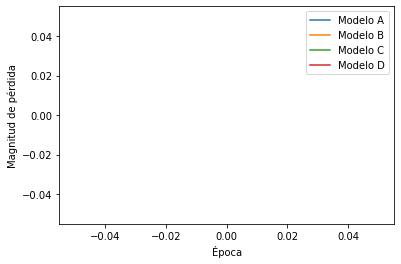

In [ ]:
# Ponemos la misma semilla para que salgan los mismos resultados en cada ejecución
#np.random.seed(9999)

# Entrenamos el modelo
# - Las epocas es cuantas vueltas da el modelo
# - El lote es cuantas muestras de Y usamos para entrenar el modelo cada vez
epocas = 1000
lote   = 32
print("Comenzando a entrenar...")


# Modelo A
print("    Modelo A...")
historialA = modeloA.fit(X, Y, epochs = epocas, batch_size = lote, verbose = False)

# Pintamos la función LOSS con respecto a las épocas
plt.xlabel("Época")
plt.ylabel("Magnitud de pérdida")
plt.plot(historialA.history["loss"], label='Modelo A')


# Modelo B
print("    Modelo B...")
historialB = modeloB.fit(X, Y, epochs = epocas, batch_size = lote, verbose = False)
plt.plot(historialB.history["loss"], label='Modelo B')


# Modelo C
print("    Modelo C...")
historialC = modeloC.fit(X, Y, epochs = epocas, batch_size = lote, verbose = False)
plt.plot(historialC.history["loss"], label='Modelo C')


# Modelo D
# El modelo D es el que más tiempo tarda en entrenar, es normal.
print("    Modelo D...")
historialD = modeloD.fit(Xnew, Ynew, epochs = epocas, batch_size = lote, verbose = False)
plt.plot(historialD.history["loss"], label='Modelo D')


# Cuando termine el entrenamiento (unos 50s) comunicamos que está terminado
print("Entrenamiento concluido")

# Pintamos la leyenda para cada modelo y mostramos el gráfico
leg = plt.legend()
plt.show()

## Evaluación del modelo

Del gráfico anterior, podemos ver que la función de pérdida es mucho mejor en el modelo D que era el más complejo. Ahora tenemos que evaluar el modelo.

En nuestro caso, no tenemos un conjunto de datos equilibrado. De hecho está muy desequilibrado con respecto al 0 (muchas más muestras) y puede dar la casualidad que el modelo más simple sea mejor.

En cualquier caso, vamos a ver la precisión y curva ROC para cada uno de los modelos.

Modelo A: 
nan
0.5

Modelo B: 
nan
0.5

Modelo C: 
nan
0.5

Modelo D: 
nan
0.500034511089325



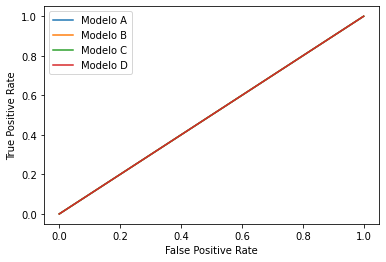

In [ ]:
# Evaluamos el modelo y mostramos LOSS y precisión
#accuracy_A = modeloA.evaluate(X,    Y,    verbose = False)
#accuracy_B = modeloB.evaluate(X,    Y,    verbose = False)
#accuracy_C = modeloC.evaluate(X,    Y,    verbose = False)
#accuracy_D = modeloD.evaluate(Xnew, Ynew, verbose = False)

print("Modelo A: ")
print(historialA.history["loss"][epocas-1])
print(historialA.history['accuracy'][epocas-1])
print()
print("Modelo B: ")
print(historialB.history["loss"][epocas-1])
print(historialB.history['accuracy'][epocas-1])
print()
print("Modelo C: ")
print(historialC.history["loss"][epocas-1])
print(historialC.history['accuracy'][epocas-1])
print()
print("Modelo D: ")
print(historialD.history["loss"][epocas-1])
print(historialD.history['accuracy'][epocas-1])
print()


# Evaluamos el modelo mostrando las curvas ROC para cada uno
modeloA_prediccion = (modeloA.predict(X,    verbose = False) > 0.5).astype(int)
modeloB_prediccion = (modeloB.predict(X,    verbose = False) > 0.5).astype(int)
modeloC_prediccion = (modeloC.predict(X,    verbose = False) > 0.5).astype(int)
modeloD_prediccion = (modeloD.predict(Xnew, verbose = False) > 0.5).astype(int)

fprA , tprA , thresholdsA = roc_curve(Y    , modeloA_prediccion)
fprB , tprB , thresholdsB = roc_curve(Y    , modeloB_prediccion)
fprC , tprC , thresholdsD = roc_curve(Y    , modeloC_prediccion)
fprD , tprD , thresholdsD = roc_curve(Ynew , modeloD_prediccion)

# Pintamos el gráfico
plt.plot(fprA, tprA, label = 'Modelo A') 
plt.plot(fprB, tprB, label = 'Modelo B') 
plt.plot(fprC, tprC, label = 'Modelo C')
plt.plot(fprD, tprD, label = 'Modelo D')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 

leg = plt.legend()

plt.show()  




## Predicciones del modelo

Para hacer predicciones simplemente le damos una matrix similar y le pedimos la salida. En este caso estoy usando la misma matrix del conjunto de entrada para demostrar el código.

In [ ]:
# Hacemos predicciones con el modelo A
predicciones = (modeloA.predict(X) > 0.5).astype(int)

# Mostramos por pantalla a ver si lo hace bien
for i in range(5):
    print("------------------")
    print()
    print("    Predicción "+str(i))
    print("        Los datos:")
    print((X.iloc[[i]]))
    print("        Deberían salir:")
    print((Y.iloc[i]))
    print("        El módelo dice:")
    print(predicciones[i][0])
    print()


906/906 [==============================] - 1s 1ms/step
------------------

    Predicción 0
        Los datos:
   sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
3   2.460474   47.09201    53.1684  46.397568    628.125   76.98898   

   sensor_06  sensor_07  sensor_08  sensor_09  sensor_10  sensor_11  \
3   13.31742   16.24711   15.69734   15.08247   38.57977   48.65607   

   sensor_12  sensor_13  sensor_39  sensor_41  new  
3   31.67221   1.579427   31.51042   30.46875    1  
        Deberían salir:
1
        El módelo dice:
0

------------------

    Predicción 1
        Los datos:
    sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
23   2.453588   49.08854    53.1684  46.267361   635.4166   79.25443   

    sensor_06  sensor_07  sensor_08  sensor_09  sensor_10  sensor_11  \
23   13.34635   16.21094   15.81308   15.08247   44.50991   51.11165   

    sensor_12  sensor_13  sensor_39  sensor_41  new  
23   37.12904   1.794096   32.55208  32.5520

## Función del modelo

Para ver la ecuación del modelo solamente hay que mostrar la matrix de pesos en cada uno de los casos.

In [ ]:
# Para el modelo A (10 x 10)

# Para el modelo B (no hay capas intermedias)

# Para el modelo C (4)



print("----------------------")
print("Modelo A: ")
print()
print("    Primera capa:")
print()
print(modeloA_ocultaA.get_weights())
print()
print("    Segunda capa:")
print()
print(modeloA_ocultaB.get_weights())
print()
print("    Salida:")
print()
print(modeloA_salida.get_weights())
print()
print("----------------------")
print()
print("Modelo B: ")
print()
print("    Salida:")
print()
print(modeloB_simple.get_weights())
print()
print("----------------------")
print("Modelo C: ")
print()
print("    Primera capa:")
print()
print(modeloC_ocultaA.get_weights())
print()
print("    Salida:")
print()
print(modeloC_salida.get_weights())
print()
print("----------------------")


----------------------
Modelo A: 

    Primera capa:

[array([[ 0.4759638 ,  0.44022614,  0.02558093,  0.22236137, -0.05563885,
        -0.09473671,  0.28389713,  0.51041245, -0.00107436, -0.16174108],
       [-0.30825132,  0.5230843 ,  0.3558853 , -0.34120068,  0.27326515,
        -0.4224939 , -0.15298401, -0.03363515,  0.0611518 ,  0.07847787],
       [ 0.46175605,  0.19135179,  0.20367917,  0.15447086,  0.42154816,
        -0.00453703, -0.5405388 , -0.40246293,  0.5698242 , -0.10222159],
       [ 0.04525525, -0.06575747, -0.33604836, -0.05334672,  0.39761007,
        -0.34525922, -0.02310602, -0.19768849,  0.539515  , -0.09858385],
       [ 0.4243442 , -0.45499304, -0.39189348, -0.40340927,  0.3472527 ,
        -0.06952666, -0.37456474,  0.48474994,  0.5834152 , -0.24545942],
       [ 0.4870908 , -0.61494625,  0.15692139,  0.3922189 ,  0.4384559 ,
         0.0398802 , -0.20054068,  0.01634089,  0.4946909 , -0.22287662],
       [-0.0564977 , -0.45974573, -0.05633519, -0.15313388, -0.


<a name="pls"></a>
# Modelo con regresión parcial de componentes (PLS regression)

Uno de los problemas más comunes cuando defines un modelo del tipo que sea, ya sea mediante machine learning, o haciendo una recta de regresión simple, es definir las variables que vas a usar para adivinar el conjunto de variables que quieres predecir.

Puede ser que las variables que elijas presenten un problema de multicolinearidad, que signica que las variables están altamente correlacionadas y significan casi lo mismo. Tu modelo va a funcionar genial con los datos que tienes, pero va a hacer predicciones muy pobres en conjuntos de datos nuevos.

Una forma de solucionar esto es mediante reducción de dimensionalidad usando PCA. Pero a PCA no le importa que las predicciones salgan bien o mal, lo que hace es intentar maximizar la variabilidad entre las componentes y la variable de salida.

Para corregir eso, se usa PLS, que mezcla la variabilidad de PCA con la correlación entre las variables de entrada y salida.

En nuestro caso vamos a usar [PLS-DA](https://www.youtube.com/watch?v=zqFZ0mEc74k) , que es un clasificador para variables discretas ya que nuestra Y puede ser 0 (la red no funciona) o 1 (la red funciona)

In [ ]:
# Importamos las librerías para trabjar con PLS y varias funciones de estadística
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from zmq import NULL

# Normalizamos las matrices X e Y. En nuestro caso ya están centradas y ninguna
# variable parace tener una escala diferente al resto que pueda afectar a la
# variabilidad, pero lo dejamos hecho por si acaso.
Xnorm = X - X.mean()
Xnorm = Xnorm / Xnorm.max()
Ynorm = Y - Y.mean()
Ynorm = Ynorm / Ynorm.max()

Aquí definimos una función que prueba todas las posibles combinaciones de componentes posibles y elige la que tiene menor MSE.

In [ ]:


# Definimos una función que va a probar la misma función de PLSR para diferentes
# cantitades de componenetes. PLSR nos va a devolver el error cuadrado medio (MSE)
# para número de componentes que le digamos. Eso lo guardamos en un vector, y
# nos quedamos con el número de componentes que hace MSE mínimo.

def optimise_pls_cv(X, Y, n_comp, plot_components=True):

    # Guardamos cual es el MSE minimo y el mejor modelo posible.
    #
    # Inicializamos el mejor resultado a MSE = 9999 y número de componentes
    # mayor al número total de variables que tenemos. Este es un resultado
    # imposible y está programado así a drede.
    #
    # Así forzamos a que la primera opción mejore el mejor resultado de
    # inicialización y no hace falta hacer casos especiales dentro del bucle.
    mse_minimo        = 99999
    mejor_componentes = n_comp + 10
    mejor_modelo_pls  = NULL
    mejor_validacion  = NULL

    # Guardamos todos los MSE aquí.
    mse = []

    # Generamos un vector con cada una de las cantidades de componentes posibles
    component = np.arange(1, n_comp)

    # Para componente, hacemos PLSR y encontramos el MSE
    for i in component:

        # Hacemos PLS
        modelo_pls_actual = PLSRegression(n_components = i)

        # Hacemos validación cruzada para ver que tal se comporta el modelo
        #
        # ---- Calculamos los Ŷ
        #
        #      El número por defecto para hacer la validación cruzada es 5,
        #      yo aquí le he puesto 10 sin ningún motivo en especial.
        #      
        y_cv = cross_val_predict(modelo_pls_actual, X, Y, cv = 10)

        # ---- Hayamos MSE
        mse_actual = mean_squared_error(Y, y_cv) 
        mse.append(mse_actual)
        # 
        # comp = 100 * ( i + 1) / n_comp

        # Actualizamos el mejor modelo posible si encontramos uno mejor
        if(mse_minimo > mse_actual):
            mse_minimo        = mse_actual
            mejor_componentes = i
            mejor_modelo_pls  = modelo_pls_actual
            mejor_validacion  = y_cv


    # Indicamos cual ha sido el mejor número de componentes
    print("Sugerimos usar este número de componentes: ", mejor_componentes)

    # Opcionalmente, podemos enseñar la gráfica con los valores de MSE
    if (plot_components):
        with plt.style.context(('ggplot')):
             plt.plot( component,         np.array(mse), '-v', color = 'blue', mfc = 'blue')
             plt.plot( mejor_componentes, mse_minimo,    'P', ms = 10, mfc = 'red')
             plt.xlabel('Número de componentes PLS')
             plt.ylabel('MSE')
             plt.title('PLS')
             plt.xlim(left=-1)

        plt.show()


    # Ajustamos los datos al mejor modelo encontrado
    mejor_modelo_pls.fit(X, Y)
    y_c = mejor_modelo_pls.predict(X)

    # Calculate scores for calibration and cross-validation
    score_c  = r2_score(Y, y_c)
    score_cv = r2_score(Y, mejor_validacion)

    # Calculate mean squared error for calibration and cross validation
    mse_c  = mean_squared_error(Y, y_c)
    mse_cv = mean_squared_error(Y, mejor_validacion)

    print('R2 calib:'  + str(score_c))
    print('R2 CV:'     + str(score_cv))
    print('MSE calib:' + str(mse_c))
    print('MSE CV:'    + str(mse_cv))

    # Plot regression and figures of merit
    rangey = max(Y) - min(Y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(Y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, Y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,Y), Y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(Y, Y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')

    plt.show()

    return mejor_componentes 

Probamos la función anterior con nuestros datos de entrada.

Para el modelo simple con 10 columnas y 100 filas, el PLS no funciona bien. $R^2$ = 0.02 y el número de componentes que mejor se ajusta es 1.

Para el modelo real, si es algo más aceptable, $R^2$ = 0.89 y el número de componentes se reduce de 52 a 11.

In [ ]:
optimise_pls_cv(Xnorm,Ynorm, totalInputsColumns , plot_components=True)

ValueError: ignored

Hay que probar añadiendo la $Y_{-1}$ al modelo PLS


Probar a filtrar los datos reales. Seleccionar las filas con 0, y probar a elegir las X filas antes de cada 0 para balancear los datos.



Repetir:
- Seleccionar todos los 0 y elegir X veces el número de 1
- Apuntar el AUC y encontrar la media
- Apuntar que sensores son los más importantes y añadirlos al bin



# **Morfólogía de la red**

Importamos las librerias para el árbol de decisiones

In [ ]:
# Importamos las librearías para crear modelos de árbol de decisión
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.tree import export_text

import seaborn as sns

Convertimos las entradas X a escala binaria

In [ ]:
Xbinario = pd.DataFrame(index=range(totalInputsRows),columns=range(totalInputsColumns))
Xbinario.columns = X.columns

for i in range(totalInputsRows):
    for j in range(totalInputsColumns):
        Xbinario.iloc[i,j] = 1
        if(X.iloc[i,j] <= 0.5): Xbinario.iloc[i,j] = 0

Xbinario.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,1
3,0,0,0,1,1,1,1,0,1,1
4,0,0,1,1,1,1,1,1,1,1


In [ ]:

# Dividimos en partes para aprendizaje, y partes para evaluar
# -- Test Size = 0.2 significa un 20% para evaluar
# -- Random State = 0 significa que divida de forma aleatoria, pero siempre igual para poder reproducir el problema de nuevo
X_Train, X_Test, Y_Train, Y_Test = train_test_split(Xbinario,Y,test_size = 0.2, random_state=0)

In [ ]:
# Creamos el tipo de modelo que queremos, en nuestro caso, árbol de decisión.
# -- Max Depth es el límite de condiciones que ponemos, en teoría infinito, pero si no ponemos un límite el modelo entrena hasta el fin de los tiempos. 
tr = tree.DecisionTreeClassifier(max_depth=5)

# Entrenamos el modelo
tr.fit(X_Train, Y_Train)

f1Score = tr.score(X_Test,Y_Test)
f1Score = f1Score * 100
f1Score = round(f1Score,2)
f1Score

90.0

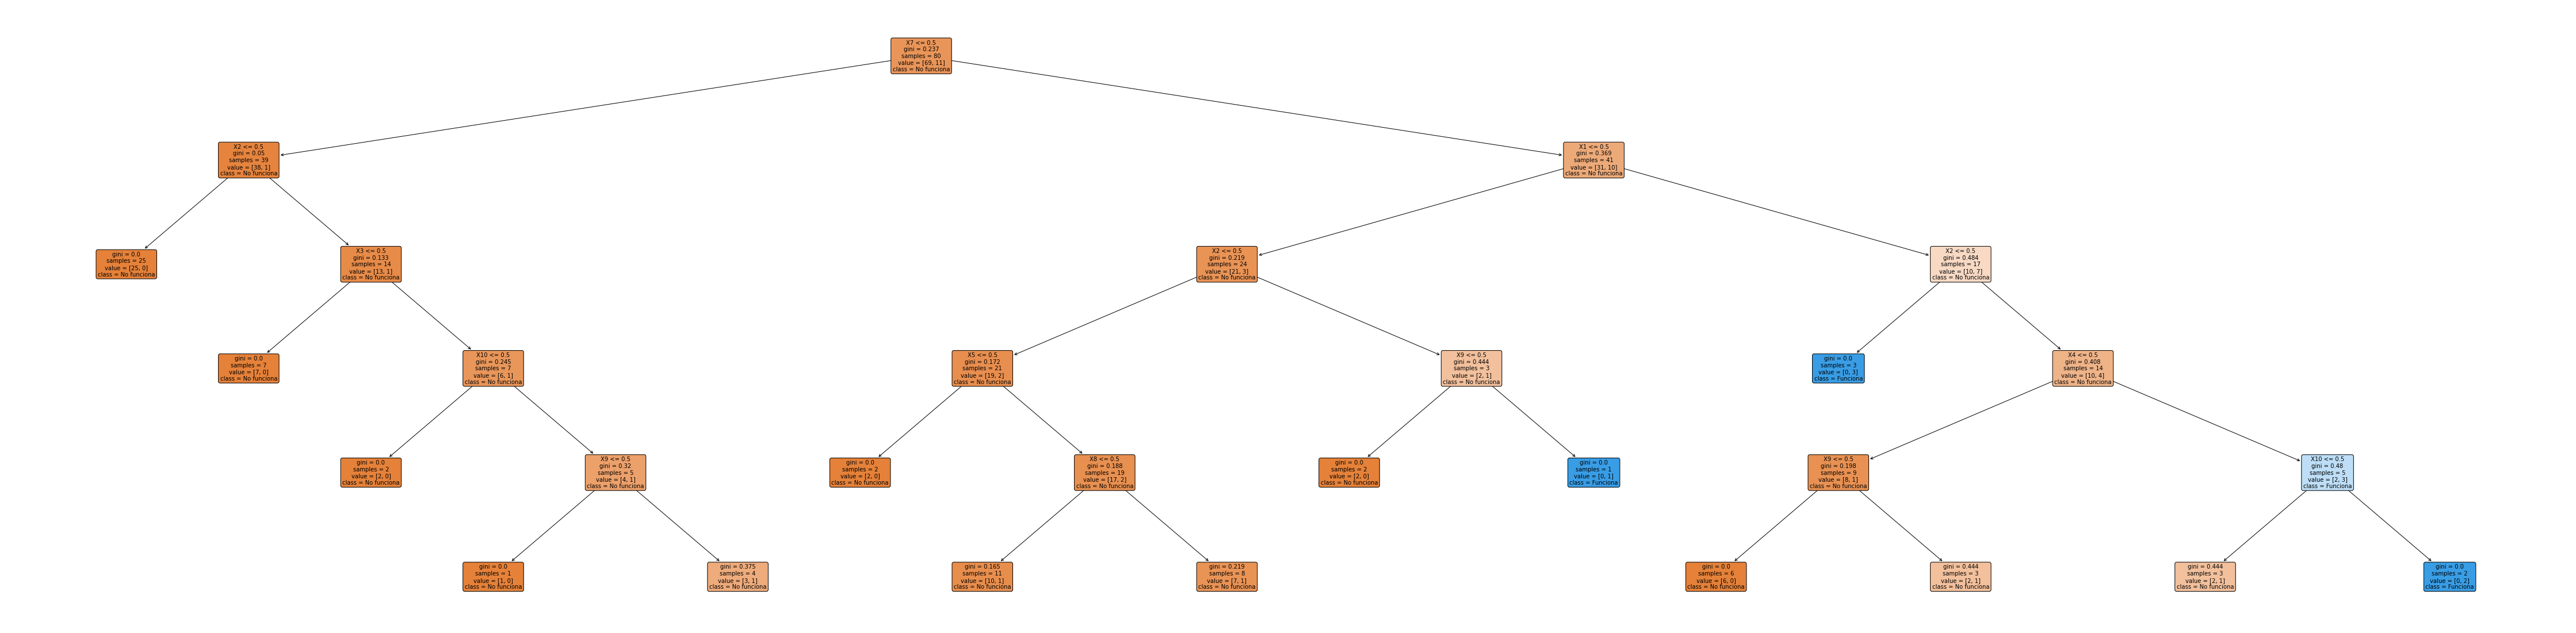

In [ ]:
valores = ["No funciona","Funciona"]  
nombresColumnas = Xbinario.columns

# Preparamos un diagrama de tamaño 60 x 20
plt.figure(figsize=(80,20))

# Le decimos a la librería que prepare el diagrama
# -- Con nuestro modelo tr
# -- Que incluya los nombres de las variables
# -- Que incluya el nombre de los valores de la variable dependiente
# -- Que redondee los números mostrados
# -- Que ponga colorines a las cajitas
# -- Y que el tamaño de letra no sea muy grande
a = tree.plot_tree(tr,
                   feature_names = nombresColumnas,
                   class_names = valores,
                   rounded = True,
                   filled = True,
                   fontsize=10)

plt.show()

Lo que me dice el diagrama es:

La red puede funcionar si:

A) X7 > 1 , X1 < 0 , X2 > 1 , X9 > 1

B) X7 > 1 , X1 > 1 , X2 < 0

C) X7 > 1 , X1 > 1 , X2 > 1 , X4 < 0 , X10 > 1

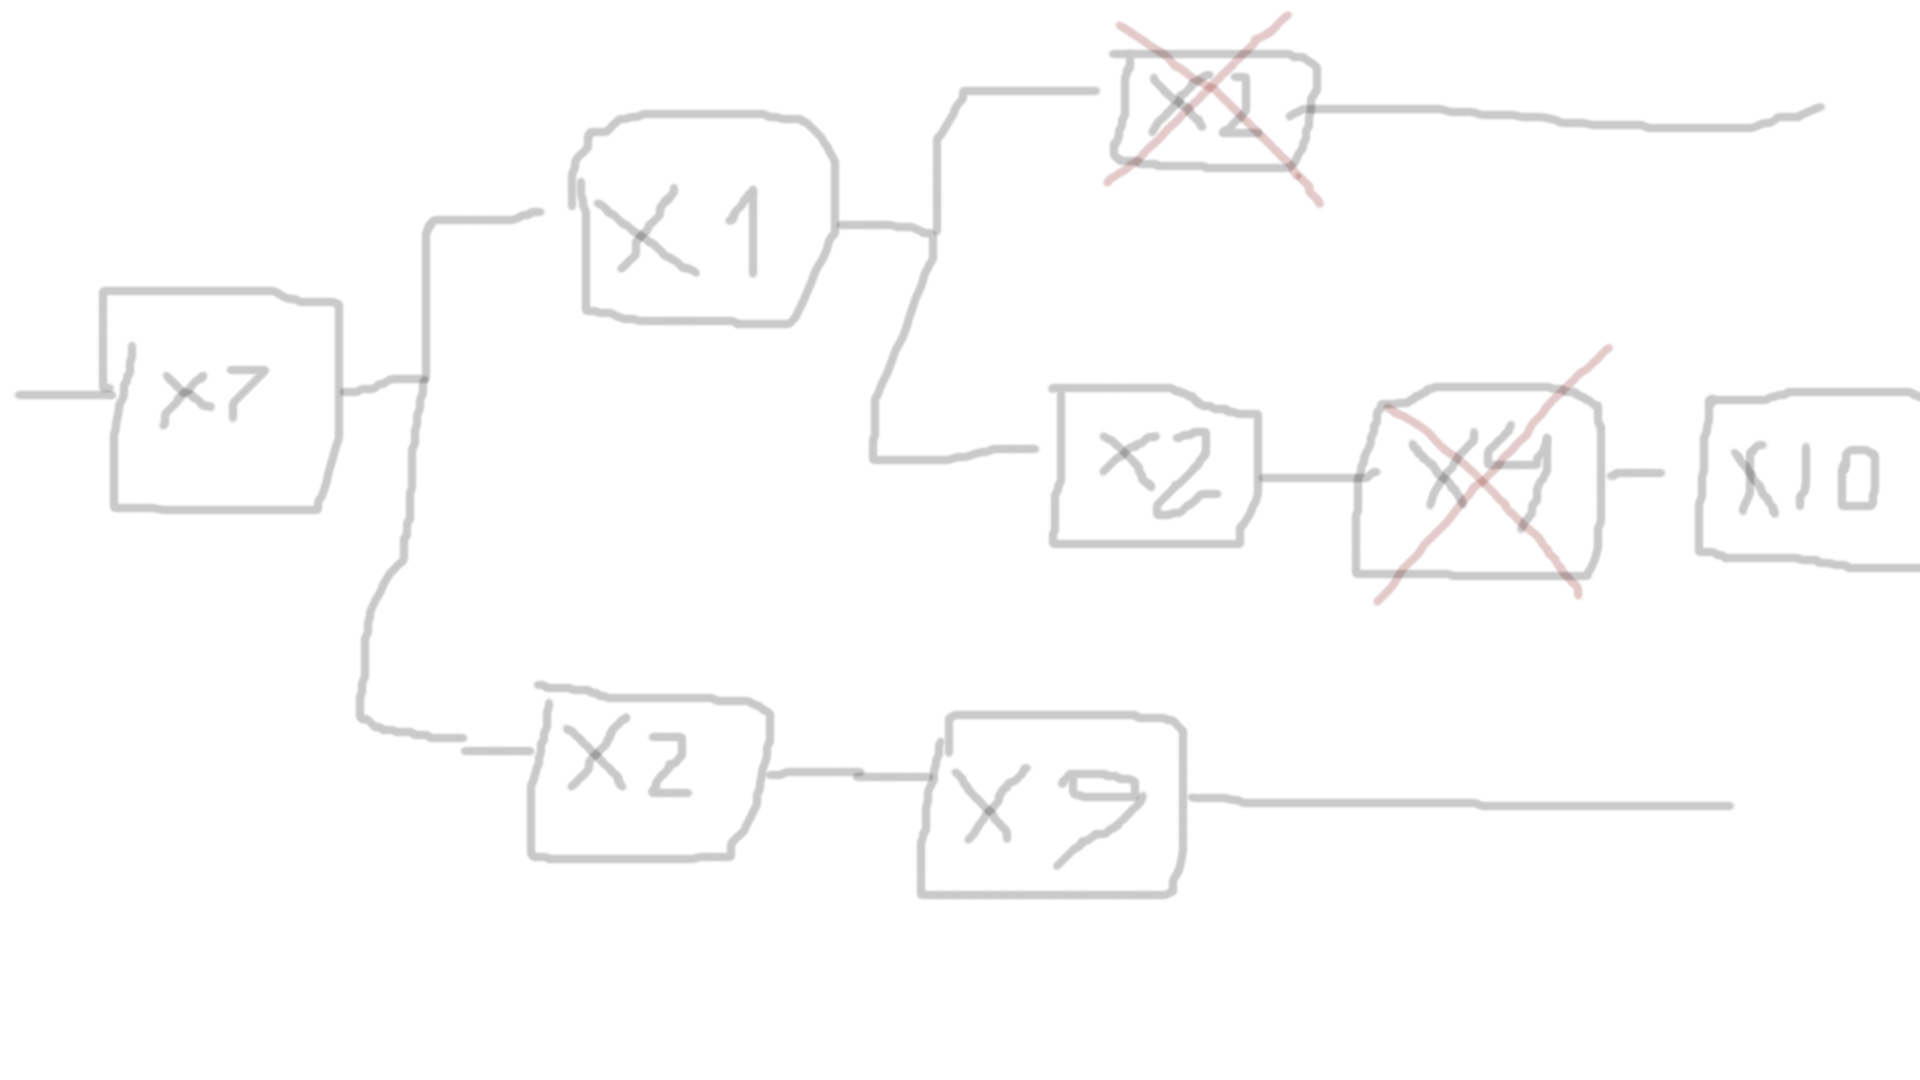